# XNICER example

Marco Lombardi, 30 May 2020

## Compilation

The code includes some Cython-generated modules which needs to be compiled using a C compiler. This can be done locally, without installing the package, using the following command a terminal
```
python setup.py build_ext --inplace
```
Alternatively, if a Cython recompilation is desired (really necessary only if the Cython code is modified, which is not the typical case for the end-user), one can use the command
```
python setup.py build_ext --inplace --use-cython
```

After the code has been compiled, it is possible to run some tests by calling in the terminal `pytest` from the package directory (this step is clearly optional).

In [1]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from xnicer import XNicer, XDGaussianMixture, guess_wcs, make_maps
from xnicer.catalogs import PhotometricCatalogue, AstrometricCatalogue

## Data Preparation

### Data loading

The following lines load the control field catalogue. This catalogue must contain the magnitudes measurements and the associated errrs for each star in the control field. It is assumed that no extinction is present there. We present different techniques to load the data, to show the flexibility one has in this respect.

---
As first possibility we load the data from CDS using the `astroquery` package. We use the VISION dataset in Orion, and we get the control field dataset as a simple astropy table.

In [2]:
from astroquery.vizier import Vizier

my_vizier = Vizier(columns=['RAJ2000', 'DEJ2000', 'Jmag', 'e_Jmag', 
                            'Hmag', 'e_Hmag', 'Ksmag', 'e_Ksmag', 'ClassSex'])
my_vizier.ROW_LIMIT = -1
cat_c = my_vizier.get_catalogs('J/A+A/587/A153/control')[0]
cat_c[:5]

RAJ2000,DEJ2000,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,ClassSex
deg,deg,mag,mag,mag,mag,mag,mag,
float64,float64,float32,float32,float32,float32,float32,float32,float32
93.689293,-27.009006,13.082,0.005,12.578,0.004,12.474,0.006,1.000
93.316417,-27.140401,13.482,0.008,12.960,0.006,12.995,0.012,1.000
93.482342,-27.082041,13.836,0.008,13.561,0.008,13.513,0.012,0.885
94.366133,-26.768187,13.106,0.011,12.845,0.007,12.754,0.018,0.999
93.381005,-27.118228,14.439,0.013,13.845,0.009,13.717,0.019,0.888


---
As a second possibility we coonect to CDS through a TAP+ service and directly perform a query.

In [3]:
from astroquery.utils.tap.core import TapPlus

tap = TapPlus(url="http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
job = tap.launch_job_async("""
SELECT RAJ2000, DEJ2000, Jmag, e_Jmag, Hmag, e_Hmag, Ksmag, e_Ksmag, ClassSex
FROM "J/A+A/587/A153/control"
""", output_format="votable")
cat_c = job.get_results()
cat_c[:5]

Created TAP+ (v1.2.1) - Connection:
	Host: TAPVizieR.u-strasbg.fr
	Use HTTPS: False
	Port: 80
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]


RAJ2000,DEJ2000,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,ClassSex
deg,deg,mag,mag,mag,mag,mag,mag,
float64,float64,float64,float64,float64,float64,float64,float64,float64
93.856182,-26.959005,--,--,14.826,0.023,14.903,0.044,1.0
93.871183,-26.951021,--,--,--,--,18.31,0.24,1.0
93.873047,-26.950594,--,--,18.722,0.176,18.203,0.229,1.0
93.865984,-26.954553,--,--,18.186,0.126,18.233,0.224,1.0
93.864373,-26.953793,--,--,17.527,0.085,17.491,0.135,1.0


---
We also show here how to convert the previous table into a VOTable: this is useful since, for these tables, the interpretation of the columns is simplified (through the use of the ucd's). Note, that for this step to work nicely, the original ucd's must not be coorrupted: these can be shown by printing `cat_c_vo.fields` below.

In [4]:
from astropy.io.votable import from_table

cat_c_vo = from_table(cat_c).get_first_table()

---
Finally, we can also load the data from a local file. Only run this line after you have modified the path to a folder where you have downloaded all the relevant files from CDS (catalogue J/A+A/587/A153).

In [5]:
try:
    path = '/Users/mlombard/TeX/art64/Vision/'
    cat_c = ascii.read(path + 'control.dat', readme=path + 'ReadMe')
except FileNotFoundError:
    print("Make sure you have loaded the files using one of the techniques above")

### Control field photometric catalogue

We generate a `PhotometricCatalogue` object from the data just loaded. This is just a table with a few columns, including `"mags"`, with the array of magnitudes for each star, and `"mag_errs"`, with the associated errors.

A `PhotometricCataloogue` can be generated using different techniques: using a a VO table (through the method `from_votable`), using a generic table (as in our case, `from_table`), or directly from arrays of photometric data (`from_photometry`).

When generating the `PhotometricCatalogue` we must also pass the reddening law: this is an array with the ratios $A_{\rm band} / A_{\rm ref}$ for each band: that is, the extinction on each band over the extinction at a reference band. The ratio must be provided in the same order as the magnitude (and the magnitude errors). Here we take $K$ as a reference band, so the last value of the vector `reddening_law` is unity.

In our case, we also have an approximate classification of objects into two classes (stars and galaxies) through the `ClassSex` column. We can include this piece of information in the catalogue, as this will generally improve the extinction measurements. To this purpose, we need to provide the class names and the associated columns containing the class probabilities (that is, the probability for the object to belong to each class). Since the class probabilities per object must sum up to unity, one can omit the last probability. In our case we have two classes, `"star"` and `"galaxy"`, and we just provide the column associated to the probability of the object to be a star, `"ClassSex"`. Notice that these probabilities can also be entered in logaritmic form.

The last line is a call to `add_log_probs`. This method simply add a column with log probabilities to the catalogue. This column is initially filled with zeros; this is then used later on to statistically model the effects of an extinction.

In [6]:
# Create a photometric catalog for the control field data. For this catalogue,
reddening_law = [2.50, 1.55, 1.00]
mags = ["Jmag", "Hmag", "Ksmag"]
mag_errs = ["e_Jmag", "e_Hmag", "e_Ksmag"]
phot_c = PhotometricCatalogue.from_table(cat_c, mags, mag_errs, 
                              reddening_law=reddening_law,
                              class_names=["star", "galaxy"], class_prob_names=["ClassSex"],
                              log_class_probs=False, dtype=np.float64)
phot_c.add_log_probs()
phot_c[:5]

idx,mags [3],mag_errs [3],log_class_probs [2],log_probs [3]
,mag,mag,,
int64,float64,float64,float64,float64
0,13.082 .. 12.474,0.005 .. 0.006,+0.000 .. -inf,+0.000 .. +0.000
1,13.482 .. 12.995,0.008 .. 0.012,+0.000 .. -inf,+0.000 .. +0.000
2,13.836 .. 13.513,0.008 .. 0.012,-0.122 .. -2.163,+0.000 .. +0.000
3,13.106 .. 12.754,0.011 .. 0.018,-0.001 .. -6.908,+0.000 .. +0.000
4,14.439 .. 13.717,0.013 .. 0.019,-0.119 .. -2.189,+0.000 .. +0.000


---
Alternatively, one can use the VOTable to create the photometric catalogue.

In [7]:
PhotometricCatalogue.from_votable(cat_c_vo, class_names=["star", "galaxy"], class_prob_names=["ClassSex"],
                                  log_class_probs=False)[:5]

idx,mags [3],mag_errs [3],log_class_probs [2]
,mag,mag,
int64,float32,float32,float32
0,15.000 .. 14.903,99.999 .. 0.044,+0.000 .. -inf
2,15.000 .. 18.203,99.999 .. 0.229,+0.000 .. -inf
3,15.000 .. 18.233,99.999 .. 0.224,+0.000 .. -inf
4,15.000 .. 17.491,99.999 .. 0.135,+0.000 .. -inf
5,19.018 .. 17.694,0.135 .. 0.154,-1.474 .. -0.260


### Optional step: characterization of photometric data

Optionally, we can characterize the number counts of objects and the relationship between photometric errors and magnitudes. These are important to correct for unresoved inhomogeneities in the extinction maps (XNICEST algorithm). 

In [8]:
phot_c.fit_number_counts()
phot_c.fit_phot_uncertainties();

We can verify the results of the number count fit with the `plot_number_counts` procedure. The accuracy of the fit is important only close to the completeness limit: it is important to characterize the completeness function.

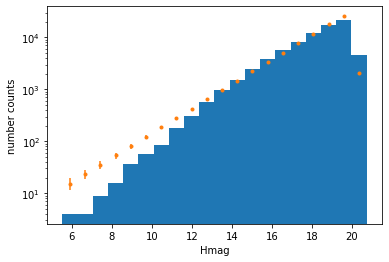

In [9]:
phot_c.plot_number_counts(band=1, bins=20)

---
Similarly we can check the accuracy of the photometric uncertainties using the `plot_phot_uncertainties` method. This shows a density plot with 

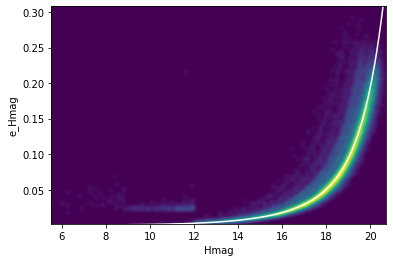

In [10]:
phot_c.plot_phot_uncertainties(band=1)

## Extreme Deconvolution

We now perform an extreme deconvolution of the colors in the control field.

To this purpose, we create an `XDGaussianMixture` object. The basic parameter `n_components`, which fixes the the number of components in the deconvolution. If the catalogue include classes, these by default are also considered in the decoonvolution.

As second step we create an `XNicer` object, passing the newly created `XDGaussianMixture` object as first argument. The second argument is a list of extinctions to consider: the deconvolution is performed by artificially extinguishing the control field photometric catalogue at these set of values. The first extinction in the array must always be zero.

Finally, the last line performs thee extreme deconvolution. This can take quite some time, depending on the size of the control field. The code by default runs in parallel using all CPUs available. If the ipywidgets is installed, it is shown with the package [tqdm](https://tqdm.github.io) to show a barline. 

In [18]:
%%time
xd = XDGaussianMixture(n_components=5, n_classes=2)
xnicer = XNicer(xd, np.linspace(0.0, 6.0, 7))
xnicer.fit(phot_c)

CPU times: user 5min 56s, sys: 2.7 s, total: 5min 59s
Wall time: 36 s


---
The calibration below is used for the XNicest algorithm: it computes the XNicest weights and bias corrections. That line can also be slow. It is not necessary, unless one desires to use the XNicest algorithm. In any case, it also reduces the bias of algorithm at high extinction values

In [19]:
%%time
xnicer.calibrate(phot_c, np.linspace(-1.0, 6.0, 71), update_errors=False)


CPU times: user 3min 52s, sys: 10.6 s, total: 4min 2s
Wall time: 57.8 s


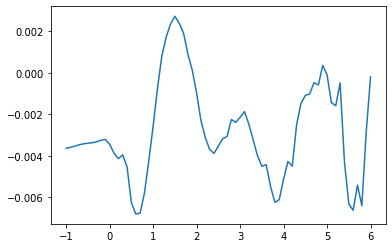

In [21]:
plt.plot(xnicer.calibration[0], xnicer.calibration[1]);

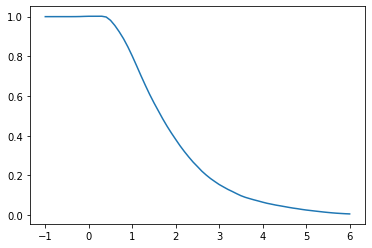

In [22]:
plt.plot(xnicer.calibration[0], xnicer.calibration[2]);

### Control field checks

We can now measure how the algorithm works on the control field data. This step is performed below by simply asking an estimate of the extinction for each control field star using the `predict` method. For this test, we can use all stars, or only stars with complete measurements in all bands.

We can then also compute a few relevant quantities: the bias (difference between average predicted extinction and true extinction, which vanishes here), the mean squared error (MSE), and the predicted error (Err). For all these computations we weight differently the stars, using our information on the accuracy of each extinction measurement: this is carried by the `variance_A` field of the `ExtinctionCatalogue` produced by `predict`. Ideally, we want the bias to vanish, the MSE to be as small as possible, and the predicted error to be as close to the MSE as possible.

Bias = 0.000
MSE  = 0.154
Err  = 0.154


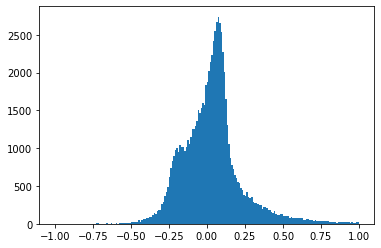

In [23]:
# This is the standard way to proceed using all stars

# Compute the extinction from the color catalogue
ext_c = xnicer.predict(phot_c.get_colors())
# Compute the weights as the inverse of each extinction measurement
weight_c = 1.0 / ext_c['variance_A']
# We normalize the weight_c so that its mean is unity: this simplifies
# some of the equations below
weight_c /= np.mean(weight_c)
# The bias is the weighted sum of the extinction measurements
bias_c = np.mean(ext_c['mean_A'] * weight_c)
# The mean squared error is computed below
mse_c = np.sqrt(np.mean((ext_c['mean_A'] * weight_c) ** 2))
# Average estimated variance: should be close to the MSE
err_c = np.sqrt(np.mean(ext_c['variance_A'] * weight_c**2))
# We also make an histogram plot
plt.hist(ext_c['mean_A'], bins=200, range=[-1, 1])
print(f"Bias = {bias_c:.3f}")
print(f"MSE  = {mse_c:.3f}")
print(f"Err  = {err_c:.3f}")

In [24]:
# Same procedure using a subset of stars: only the ones with complete bands.
w = np.where(np.all(phot_c['mag_errs'] < phot_c.meta['null_err'], axis=1))[0]
ext_c = xnicer.predict(phot_c[w].get_colors())
weight_c = 1.0 / ext_c['variance_A']
weight_c /= np.mean(weight_c)
bias_c = np.mean(ext_c['mean_A'] * weight_c)
mse_c = np.sqrt(np.mean((ext_c['mean_A'] * weight_c) ** 2))
err_c = np.sqrt(np.mean(ext_c['variance_A'] * weight_c**2))
print(f"Bias = {bias_c:.3f}")
print(f"MSE  = {mse_c:.3f}")
print(f"Err  = {err_c:.3f}")

Bias = -0.007
MSE  = 0.141
Err  = 0.143


### Simulated extinction

As a second possibility, we can artificially extinguish the control field stars and check that we are able to recover the applied extinction. In doing this test, we need to take into account the fact that when stars are extinguished, we can have two different effects:
- the extincted star will generally have larger photometric errors;
- some of the band measurements for thee extincted star might be missing.
Both effects can be modeled with XNICER using the `extinguish` method, provided one has performed the characterization of the control field as described above.

Regarding the possible missing measurements, we need to take into account that this is generally a stochastic event: when the extinguished magnitude gets close to the completeness limit, we *might* or *might not* detect the star. The `extinguish` and the `get_colors` method cope with this effect in two modes:
- If the photometric catalogue has no "detection probabilities" attached to it, the final catalogue is randomly censored: that is, we simulate the (in)completeness by randomly dropping magnitudes.
- If the photometric catalogu has "detection probabilities", we keep them into account and generate various combinations of colors with associated probabilities. In this latter situatioon, the color catalogue will generally have more entries than the photometric catalogue, because all possible combinations of bands measurements (with associated probabilities) are taken into account. This method is generally more robust, as it does not involve random events, but is slower and one needs to use properly the detection probabilities.

Bias = -0.011
MSE  = 0.123
Err  = 0.123


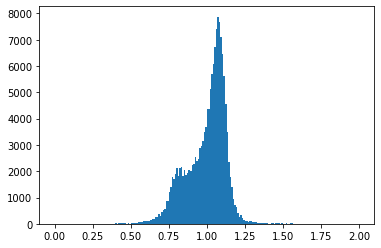

In [25]:
# This is the simulated extinction
ext = 1.0

# Extinguish the photometric catalogue and compute the colors
phot_c1 = phot_c.extinguish(ext, update_errors=False);
cols_c1 = phot_c1.get_colors()
# The following line requires that all the extinguished bands are observed
w = np.where(np.all(cols_c1['projections'] == np.identity(2), axis=(1,2)))[0]
# Alternatively, we could select all objects with
# w = slice(None)

# Compute the extinction from the color catalogue
ext_c = xnicer.predict(cols_c1[w])
# Compute the weights as the inverse of each extinction measurement. Here we
# now need to take into account the probability of each object
weight_c = 1 / ext_c['variance_A']
prob_c = np.exp(ext_c['log_weight'])
prob_c /= np.sum(prob_c)
# The bias is the weighted sum of the extinction measurements
bias_c = np.sum(prob_c * weight_c * (ext_c['mean_A'] - ext)) / np.sum(prob_c * weight_c)
# The mean squared error is computed below
mse_c = np.sqrt(np.sum(prob_c * ((ext_c['mean_A'] - ext) * weight_c) ** 2)) / \
    np.sum(prob_c * weight_c)
# Average estimated variance: should be close to the MSE
err_c = np.sqrt(np.sum(prob_c * ext_c['variance_A'] * weight_c**2)) / np.sum(prob_c * weight_c)
# We also make an histogram plot
plt.hist(ext_c['mean_A'], bins=200, range=[-1 + ext, 1 + ext])
print(f"Bias = {bias_c:.3f}")
print(f"MSE  = {mse_c:.3f}")
print(f"Err  = {err_c:.3f}")

## Science field analysis

### Data loading

We need to load the science field data: this can be done in a way similar to the control field data. The only difference is that we need now also to take into account the star coordinates (unnecessary for the control field). Therefore we build both a `PhotometricCatalogue` and an `AstrometricCatalogue`.

Again, as before, we can use different techniques to load the data: we show here just a couple of techniques.

In [26]:
# Create a photometric and an astrometric catalogue for the science field.
try:
    path = '/Users/mlombard/TeX/art64/Vision/'
    cat_s = ascii.read(path + 'science.dat', readme=path + 'ReadMe')
except FileNotFoundError:
    print("Local file not found: using the TAP+ service")
    tap = TapPlus(url="http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
    job = tap.launch_job("""
SELECT RAJ2000, DEJ2000, Jmag, e_Jmag, Hmag, e_Hmag, Ksmag, e_Ksmag, ClassSex
FROM "J/A+A/587/A153/science"
""", output_format="votable")
    cat_s = job.get_results()

phot_s = PhotometricCatalogue.from_table(cat_s, mags, mag_errs, 
                              reddening_law=reddening_law, 
                              class_names=["star", "galaxy"], class_prob_names=["ClassSex"],
                              log_class_probs=False, dtype=np.float64)
coord_s = AstrometricCatalogue.from_table(cat_s, ['RAdeg', 'DEdeg'], unit='deg', frame='icrs')
coord_s

<AstrometricCatalogue (ICRS): (ra, dec) in deg
    [(81.868386, -4.048707), (81.870123, -4.052663),
     (81.8705  , -4.052475), ..., (87.075758, -9.283329),
     (87.076066, -9.276378), (87.077855, -9.278526)]>

### Extinction measurements

These are now very simple: just call `predict` on the `xnicer` object trained above in the control field. This will generate an `ExtinctionCatalogue` with a few useful columns.

In [27]:
ext_s = xnicer.predict(phot_s.get_colors())
ext_s[:5]

idx,means_A [5],variances_A [5],log_weights [5],log_class_probs [2],log_evidence,log_weight,mean_A,variance_A,xnicest_weight,xnicest_bias
,mag,mag2,,,,,mag,mag2,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,-0.291 .. -0.446,0.05203 .. 0.05521,-0.646654 .. -3.89411,0 .. -inf,10.285,-1.11022e-16,-0.259,0.076,0.99959,0.00016
3,-0.257 .. -1.001,0.00485 .. 0.04593,-0.646654 .. -3.89411,0 .. -inf,10.8315,0,-0.296,0.147,0.99921,0.00013
4,0.464 .. 0.096,0.03033 .. 0.04172,-2.45745 .. -1.77449,-2.66696 .. -0.0719935,-0.912845,2.22045e-16,0.043,0.081,1.00529,0.00464
5,0.294 .. 0.140,0.12428 .. 0.12746,-0.688449 .. -3.81232,0 .. -inf,10.1324,4.44089e-16,0.316,0.151,1.03978,0.02451
7,1.201 .. 0.457,0.27149 .. 0.31257,-0.689827 .. -4.12254,0 .. -inf,10.9115,6.66134e-16,1.287,0.316,1.71441,0.21005


### Map making

We are now ready to build an extinction map. The first step is to define a World Coordinate System (WCS) for the map, that is, to find the geometry of the field in the sky and the coonversion from sky coordinates to map pixels. This step can be done manually, but it is much more convenient to use the `guess_wcs` procedure provided by XNICER. The parameter `target_density` fixes the desired density of objects (stars per pixel). The resulting WCS can then be modified by hand if necessary.

In [28]:
from xnicer import guess_wcs

wcs = guess_wcs(coord_s.galactic, target_density=5.0)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 211.4502  -19.35514  
CRPIX : 363.0  108.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0125  0.0125  
NAXIS : 726  210

---
We can now finally make all the maps. This step requires a smoother, which is here set by the kernel density estimation (KDE) algorithm (a fast implementation is provided). We then call `make_maps`: this creates directly a FITS HDU structure with a cube, representing various quantities. The first plane (`maps[0]`) contains the XNICER extinction map.

In [29]:
from xnicer.kde import KDE
from xnicer import make_maps

smoother = KDE(tuple(reversed(wcs.pixel_shape)), max_power=2)
hdu = make_maps(coord_s.galactic, ext_s, wcs, smoother, use_xnicest=True)
maps = hdu.data
maps.shape

(7, 210, 726)

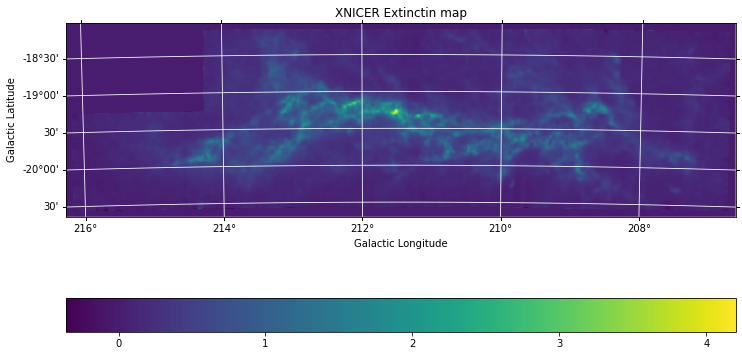

In [30]:
plt.figure(figsize=(12,10))
plt.subplot(projection=wcs)
plt.imshow(maps[0], origin='lower')
plt.grid(color='white', ls='solid')
plt.title('XNICER Extinctin map')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(orientation='horizontal');

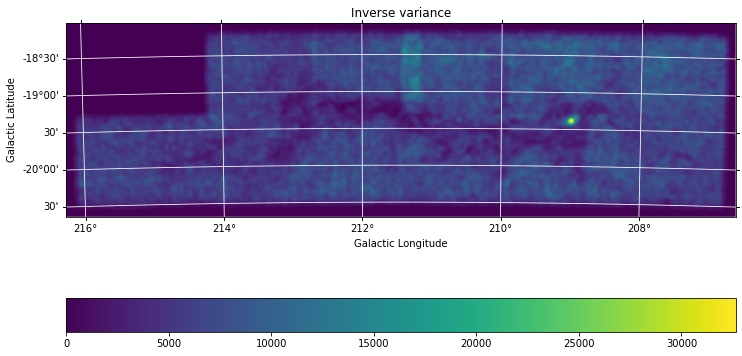

In [31]:
plt.figure(figsize=(12,10))
plt.subplot(projection=wcs)
plt.imshow(maps[1], origin='lower')
plt.grid(color='white', ls='solid')
plt.title('Inverse variance')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(orientation='horizontal');

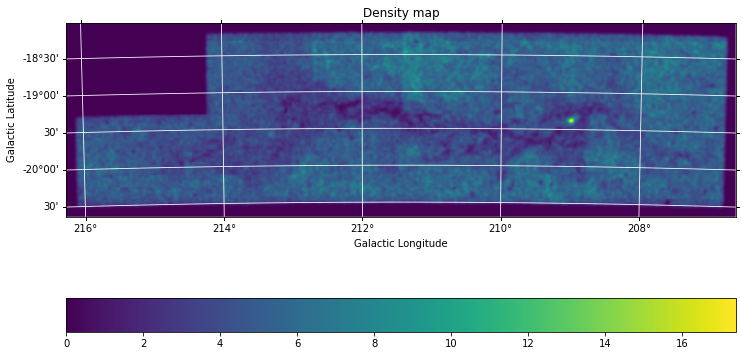

In [32]:
plt.figure(figsize=(12,10))
plt.subplot(projection=wcs)
plt.imshow(maps[3], origin='lower')
plt.grid(color='white', ls='solid')
plt.title('Density map')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(orientation='horizontal');

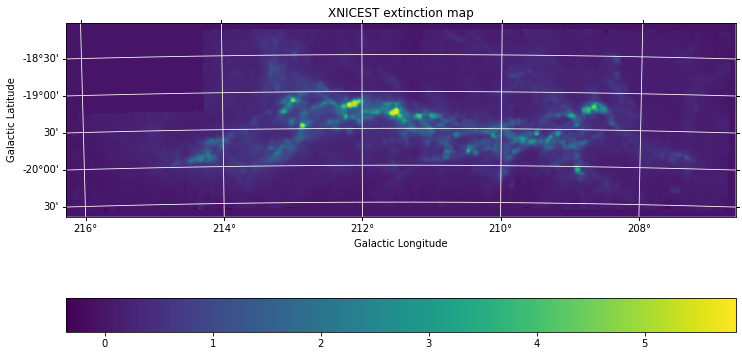

In [33]:
plt.figure(figsize=(12,10))
plt.subplot(projection=wcs)
plt.imshow(maps[4], origin='lower')
plt.grid(color='white', ls='solid')
plt.title('XNICEST extinction map')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(orientation='horizontal');